In [1]:
import tensorflow as tf
import pickle, os, sys, time
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import Model
from utils.MyRAN92_v1 import ResidualAttentionModel_92
from contextlib import redirect_stdout

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)
print(gpus)

1 Physical GPUs, 1 Logical GPUs
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
path = './models'
model_name = '/ran92_v1'
model_path = path + model_name
if not os.path.exists(model_path):
    os.makedirs(model_path)
    print(model_path)
else:
    print(model_path + ' already exists.')

history_path = model_path + '/history'
if not os.path.exists(history_path):
    os.makedirs(history_path)
    print(history_path)
else:
    print(history_path + ' already exists.')

saved_model_path = model_path + '/saved_models'
if not os.path.exists(saved_model_path):
    os.makedirs(saved_model_path)
    print(saved_model_path)
else:
    print(saved_model_path + ' already exists.')
    
checkpoint_path = history_path + "/checkpoints"
if not os.path.exists(checkpoint_path):
    os.makedirs(checkpoint_path)
else:
    print(checkpoint_path + ' already exists.')
    
graph_path = model_path + '/graphs'
if not os.path.exists(graph_path):
    os.makedirs(graph_path)
    print(graph_path)
else:
    print(graph_path + ' already exists.')

./models/ran92_v1 already exists.
./models/ran92_v1/history already exists.
./models/ran92_v1/saved_models already exists.
./models/ran92_v1/history/checkpoints already exists.
./models/ran92_v1/graphs already exists.


In [4]:
cifar10 = tf.keras.datasets.cifar10
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

In [5]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=20,
                                                          width_shift_range=0.2,
                                                          height_shift_range=0.2,
                                                          horizontal_flip=True,
                                                          validation_split=0.2)

X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

X_train = X_train - X_train.mean()
X_test = X_test - X_test.mean()

datagen.fit(X_train)

input_shape = X_train.shape[1:]
output_classes = 10

In [6]:
ran92 = ResidualAttentionModel_92(input_shape, output_classes, use_bias=True)

model = ran92.return_Model()

model.compile(tf.keras.optimizers.Adam(), 
              loss=tf.keras.losses.CategoricalCrossentropy(), 
              metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Model_Input (InputLayer)       [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 Conv1_In (Conv2D)              (None, 32, 32, 32)   896         ['Model_Input[0][0]']            
                                                                                                  
 BN_In (BatchNormalization)     (None, 32, 32, 32)   128         ['Conv1_In[0][0]']               
                                                                                                  
 ReLU_In (Activation)           (None, 32, 32, 32)   0           ['BN_In[0][0]']                  
                                                                                              

In [7]:
global summary_filename 
summary_filename = graph_path + '/{}'.format(model_name[1:]) + '_modelsummary.txt'
print(summary_filename)

./models/ran92_v1/graphs/ran92_v1_modelsummary.txt


In [8]:
with open(summary_filename, 'w') as f:
    with redirect_stdout(f):
        model.summary()

In [9]:
if not os.path.exists(checkpoint_path):
    os.makedirs(checkpoint_path)
else:
    print(checkpoint_path + ' already exists.')

./models/ran92_v1/history/checkpoints already exists.


In [10]:
checkpoint_path_ckpt = checkpoint_path + '/' + time.ctime().replace(':','_').replace(' ', '_') + '/cp-{epoch}.ckpt'
print(checkpoint_path_ckpt)

./models/ran92_v1/history/checkpoints/Tue_Dec_21_17_06_07_2021/cp-{epoch}.ckpt


In [11]:
print(checkpoint_path, '\n', checkpoint_path_ckpt )
# checkpoint_dir = os.path.dirname(checkpoint_path_ckpt)
# print(checkpoint_dir)

./models/ran92_v1/history/checkpoints 
 ./models/ran92_v1/history/checkpoints/Tue_Dec_21_17_06_07_2021/cp-{epoch}.ckpt


In [12]:
checkpoint_path_ckpt = "./models/ran92_v1/history/checkpoints/Mon_Dec_20_14_04_26_2021/cp-{epoch}.ckpt"

In [13]:
#%%

# dot_img_file = '/tmp/ran56.png'
# tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

earlyStopping_TrainAcc = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=10)
checkpoint_CB = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path_ckpt, verbose=1, save_weights_only=True)
reduceLR = tf.keras.callbacks.ReduceLROnPlateau(patience=5,  monitor='loss')
callback_list = list()
callback_list.append(earlyStopping_TrainAcc)
callback_list.append(reduceLR)
callback_list.append(checkpoint_CB)

In [14]:
checkpoint_path_ckpt

'./models/ran92_v1/history/checkpoints/Mon_Dec_20_14_04_26_2021/cp-{epoch}.ckpt'

In [15]:
model.load_weights("./models/ran92_v1/history/checkpoints/Mon_Dec_20_14_04_26_2021/cp-200.ckpt")

In [16]:
#%%
# Train the model with the new callback
ran92_v1_history = model.fit(datagen.flow(X_train, y_train, batch_size=64, subset='training'), 
                             validation_data=datagen.flow(X_train, y_train, batch_size=64, subset='validation'),
                    epochs=200, callbacks=callback_list) # callbacks)

Epoch 1/200
568/625 [==========================>...] - ETA: 6s - loss: 0.0413 - accuracy: 0.9859

KeyboardInterrupt: 

TypeError: 'History' object is not subscriptable

In [48]:
plot_loss_filename = graph_path + '/ran92_v1_Loss.png'
print(plot_loss_filename)
plot_acc_filename = graph_path + '/ran92_v1_Accuracy.png'
print(plot_acc_filename)

./models/ran92_v1/graphs/ran92_v1_Loss.png
./models/ran92_v1/graphs/ran92_v1_Accuracy.png


TypeError: 'History' object is not subscriptable

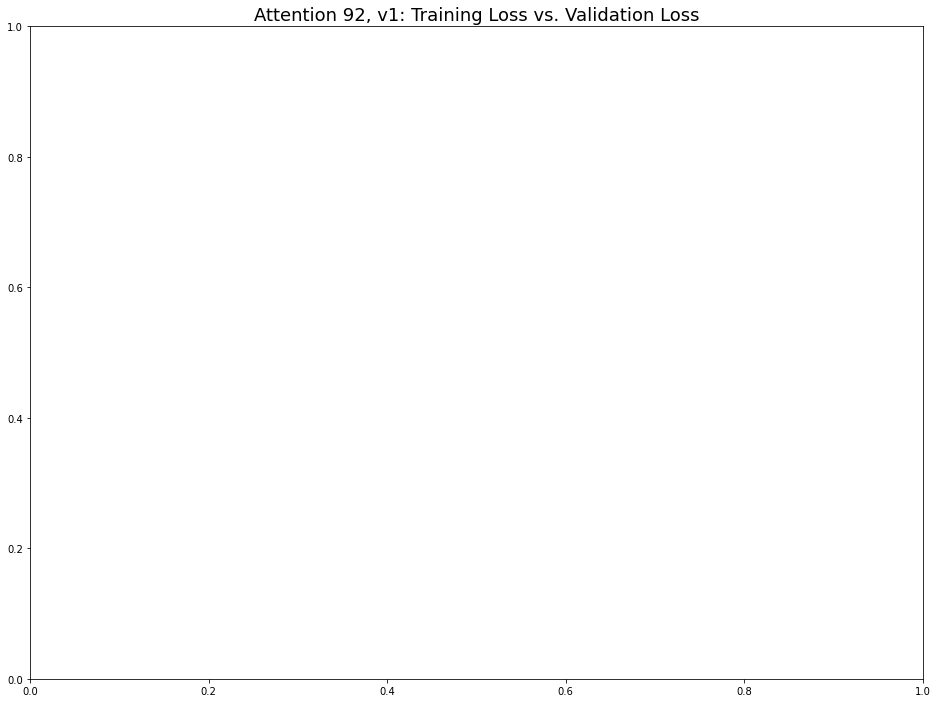

In [49]:
plt.figure(figsize=(16,12))
plt.title("Attention 92, v1: Training Loss vs. Validation Loss", fontsize=18)
plt.plot(ran92_v1_history.history['loss'], label='training loss', color='red')
plt.plot(ran92_v1_history.history['val_loss'], label = 'validation loss', color='blue')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=12)
plt.savefig(plot_loss_filename)
plt.show()

In [ ]:
plt.figure(figsize=(16,12))
plt.title("Attention 92, v1: Training Accuracy vs Validation Accuracy", fontsize=18)
plt.plot(ran92_v1_history.history['accuracy'], label='training accuracy', color='g')
plt.plot(ran92_v1_history.history['val_accuracy'], label = 'validation accuracy', color='c')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=12)
plt.savefig(plot_acc_filename)
plt.show()

In [ ]:
history_filename = history_path + '/ran92_v1_history_' + time.ctime().replace(' ','_').replace(':','_')
print(history_filename)

In [22]:
model.load_weights(checkpoint_path)

PermissionError: [Errno 13] Unable to open file (unable to open file: name = './models/ran92_v1/history/checkpoints', errno = 13, error message = 'Permission denied', flags = 0, o_flags = 0)

In [ ]:
np.save(path+'{}.npy'.format(history_filename),ran92_v2_history.history)

In [43]:
model.save(saved_model_path + '/ran92_v1_FULL_MODEL_' +  time.ctime().replace(' ','_').replace(':','_'))

INFO:tensorflow:Assets written to: ./models/ran92_v1/saved_models/ran92_v1_FULL_MODEL_Mon_Dec_20_18_26_00_2021\assets


INFO:tensorflow:Assets written to: ./models/ran92_v1/saved_models/ran92_v1_FULL_MODEL_Mon_Dec_20_18_26_00_2021\assets
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Users\suman\anaconda3\envs\p38\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [7]:
model.load_weights("./models/ran92_v1/history/checkpoints/Mon_Dec_20_14_04_26_2021/cp-200.ckpt")

In [8]:
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

In [9]:
preds = model.predict(X_test)
preds = np.argmax(preds, axis=1)
y_true = np.argmax(y_test,axis=1)



In [10]:
acc = accuracy_score(y_true, preds)
cr=  classification_report(y_true, preds)
print(f"Accuracy: {acc}")
print(cr)


Accuracy: 0.9163
              precision    recall  f1-score   support

           0       0.92      0.94      0.93      1000
           1       0.95      0.96      0.95      1000
           2       0.90      0.90      0.90      1000
           3       0.86      0.80      0.83      1000
           4       0.90      0.93      0.91      1000
           5       0.90      0.84      0.87      1000
           6       0.90      0.97      0.93      1000
           7       0.96      0.94      0.95      1000
           8       0.95      0.94      0.95      1000
           9       0.92      0.95      0.94      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000

